# **Early Credit Default Detection from Application Stage Data**
### Balancing Customer Experience and Financial Risk

### **[Project Summary]**
- **Research Question:**\
  How can machine learning be used to effectively detect potential credit defaults using only client application data at the first stage filter, enhancing client experience while maintaining low financial risk?

- **Goal**:\
  Build a fast and cost efficient prescreening model that identifies high risk clients early using only application data, so that only low risk clients proceed to the next stage while others undergo manual review or external checks.

- **Data**:\
  Home Credit Default Risk (Recent + Past Application data)
- **Key Results**:\
  Achieved a 12.89% improvement in recall with a stable precision and F1 score, optimizing for early default detection.
- **Tech Stack**:\
  Python, Pandas, Numpy, Scikit-learn, RandomForest, LightGBM, Imbalanced-learn, Matplotlib, Seaborn

- **Project Outline**
  1. Preprocessing of Recent Applications
  2. Model and Method Selection
  3. Modeling on Recent Applications
  4. Preprocessing of Past Applications and Merging with Recent Data
  5. Modeling on Merged Application Dataset

# Imports


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore")

# 1. Recent Application Preprocessing

Begin with the recent (current) application dataset to build the first stage model.


## 1.1 Data Basics

Checked dataset structure, missing values, and duplicate records to assess overall data quailty.


In [ ]:
curr = pd.read_csv("../data/application/current_application.csv")

In [4]:
curr.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
curr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [6]:
print(f"number of columns including null: {(curr.isnull().sum() > 0).sum()}")

number of columns including null: 67


In [7]:
print(f"number of duplicated records: {curr.duplicated().sum()}")

number of duplicated records: 0


**[Data Basics]**
- The dataset contains 307511 rows with 122 columns.
- 67 columns have missing values.
- There are no duplicate records in the dataset.


## 1.2 Exploratory Data Analysis (EDA) & Data Cleaning
Identified target distribution, missingness patterns, and key binary features.
- Removed records with high missingness and features with low impact.


### 1.2.1 Target Values

Examined whether the target variable is imbalanaced between clients with and without payment difficulties.

1: Customers with payment difficulties \
0: Customers without payment difficulties

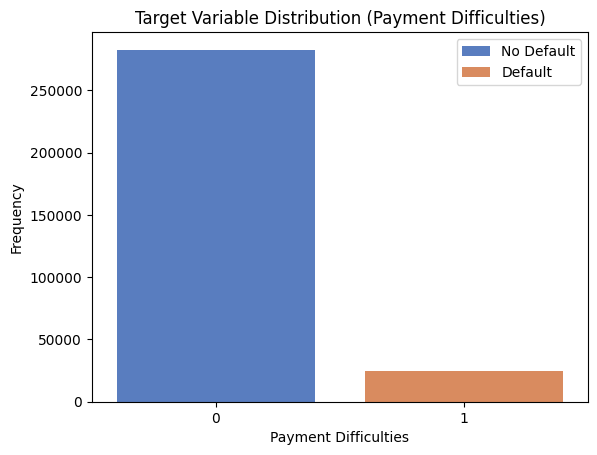

In [8]:
sns.countplot(curr, x="TARGET", hue="TARGET", palette="muted")
plt.title("Target Variable Distribution (Payment Difficulties)")
plt.xlabel("Payment Difficulties")
plt.ylabel("Frequency")
plt.legend(["No Default","Default"])
plt.show()

In [9]:
curr["TARGET"].value_counts(normalize=True)*100

,proportion
TARGET,
0,91.927118
1,8.072882


=> The target variable shows a **strong imbalance**.


### 1.2.2. Missing Values
Visualized missing rates across features containing missing values to plan imputation strategies (drop or fill).

Our Strategy:
| Missing Ratio | Action |
| ---- | ---- |
| <= 45% | Retained |
| >= 70% | Dropped |
| 45-70% | Reviewed with domain Knowledge |


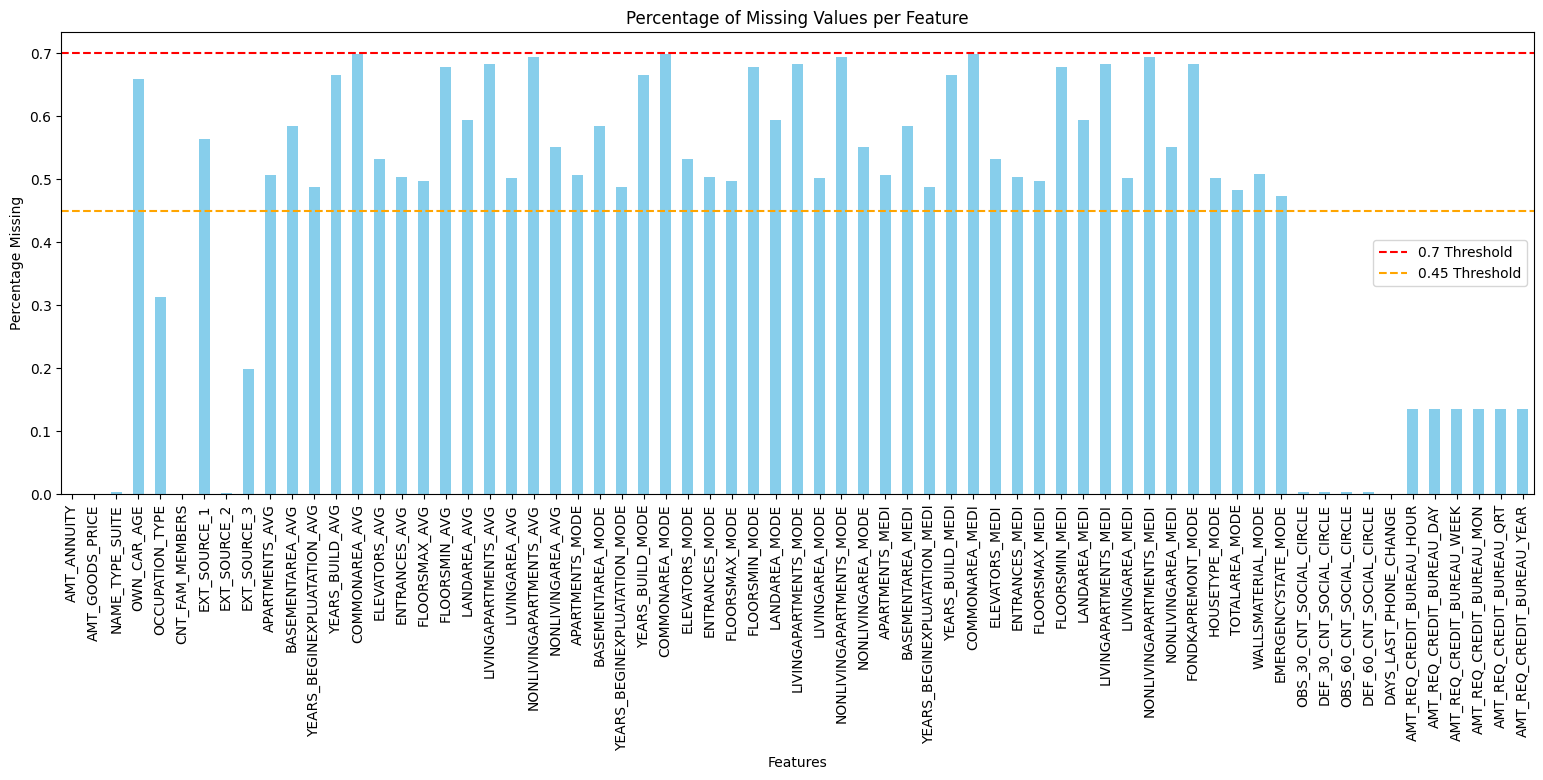

In [10]:
missing_pct = curr.isnull().mean()
col_missing = missing_pct[missing_pct>0].index
data_missing = missing_pct[col_missing]

data_missing.plot(kind="bar", figsize=(19, 6),color="skyblue")
plt.title("Percentage of Missing Values per Feature")
plt.xlabel("Features")
plt.ylabel("Percentage Missing")

plt.axhline(y=0.7, color="r", linestyle="--", label="0.7 Threshold")
plt.axhline(y=0.45, color="orange", linestyle="--", label="0.45 Threshold")
plt.legend()
plt.show()

In [11]:
missing_pct_over_45 = len(missing_pct[missing_pct>0.45].index.sort_values())
print(f"The number of columns with more than 45% missing values: {missing_pct_over_45}")

The number of columns with more than 45% missing values: 49


In [12]:
missing_pct_over_70 = len(missing_pct[missing_pct>=0.70].index.sort_values())
print(f"The number of columns with more than 70% missing values: {missing_pct_over_70}")

The number of columns with more than 70% missing values: 0


In [13]:
col_less_45 = missing_pct[missing_pct<=0.45].index
selected_over_45 = ["EXT_SOURCE_1","APARTMENTS_AVG","YEARS_BEGINEXPLUATATION_AVG","TOTALAREA_MODE","OWN_CAR_AGE"]
after_missing = list(col_less_45) + selected_over_45

In [14]:
curr = curr[after_missing]

**[Decisions]**

Based on the visualization and our defined thresholds (45%,70%),
* **Retained (<=45%)**: 73 columns were kept
* **Dropped (>=70%)**: 0 columns were dropped due to insufficient data
* **Revewied (45-70%)**:
  * (**Domain Knowledge**) External Source 1 and features associated with the client's residence and car were retained despite the high missing rate, as they are likely to be important for prediction.

### 1.2.3 Binary Columns (FLAG)
Analyzed binary FLAG columns and retained them when both conditions were met
- Difference between the two target classes is greater than 1%.
- p-value lower than 0.01 (Chi-Squared Test).

In [15]:
curr["FLAG_OWN_CAR"] = curr["FLAG_OWN_CAR"].replace({"N":0,"Y":1}).astype(int)
curr["FLAG_OWN_REALTY"] = curr["FLAG_OWN_REALTY"].replace({"N":0,"Y":1}).astype(int)

In [16]:
flags = [f for f in curr.columns if "FLAG" in f]
flags_summary = curr.groupby("TARGET")[flags].mean().T
flags_summary["diff"] = abs(flags_summary[0]-flags_summary[1])

In [17]:
p_values = []
for f in flags:
  t = pd.crosstab(curr[f], curr["TARGET"])
  chi2, p, dof, ef = chi2_contingency(t)
  p_values.append(float(p))
flags_summary["p_value"] = p_values

In [18]:
select_flag =  flags_summary[(flags_summary["diff"]>=0.01) & (flags_summary["p_value"]<=0.01)]
select_flag.sort_values("diff", ascending=False)

TARGET,0,1,diff,p_value
FLAG_DOCUMENT_3,0.704060,0.777925,0.073865,1.855748e-133
FLAG_EMP_PHONE,0.814653,0.879517,0.064864,2.530606e-143
FLAG_WORK_PHONE,0.195991,0.237825,0.041833,2.675800e-56
FLAG_PHONE,0.284238,0.244955,0.039283,9.489418e-40
FLAG_OWN_CAR,0.343176,0.305176,0.038000,9.330994e-34
FLAG_DOCUMENT_6,0.090457,0.060705,0.029752,1.425605e-56
FLAG_OWN_REALTY,0.694513,0.684109,0.010404,6.681470e-04


In [19]:
selected_flags = select_flag.index
selected_col = []
for c in curr.columns:
  if "FLAG" in c and c in selected_flags:
    selected_col.append(c)
  elif "FLAG" not in c:
    selected_col.append(c)

In [20]:
curr = curr[selected_col]

**[Results]**

* **Dropped:** 21 FLAG binary columns
* **Retained:** 5 FLAG binary columns + 52 Non Flag columns

## 1.3 Feature Engineering

Handled missing values, treated outliers, and created domain based features to improve model predictive power.



In [21]:
fill_df = curr.copy()

### 1.3.1. Missing Value Imputation
Our Strategy:
* **Low Missing Rate**: Replaced missing values with median for numerical variables, and the mode for categorical variables to preserve distributions.

* **Missing Value Indicates 0**: Replaced missing values with 0 where the null itself carried meaning.

* **High Missing Rate**: Applied feature specific impuation based on features characteristics.

#### 1.3.1.1. Low Missing Rate Features
Replaced missing values using the median (numerical) or mode (categorical).


In [22]:
low_num = ["AMT_ANNUITY", "AMT_GOODS_PRICE", "CNT_FAM_MEMBERS", "EXT_SOURCE_2", "DAYS_LAST_PHONE_CHANGE"]
low_cat = ["NAME_TYPE_SUITE"]

for c in low_num:
  median_val = fill_df[c].median()
  fill_df[c] = fill_df[c].fillna(median_val)

for c in low_cat:
  mode_val = fill_df[c].mode()[0]
  fill_df[c] = fill_df[c].fillna(mode_val)


#### 1.3.1.2. Features Where Missing Values Indicate Zero

* **Social Circle**
  * Missing values likely indicated no observations recorded for the client's social surroundings.

* **Amount Required Credit Bureau**
  * Missing values indicated that no credit bureau checks were made.

* **Apartment related Features**
  * Missing values likely indicated that the client did not own an apartment.


In [23]:
meaningful_zero = ["OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE","DEF_60_CNT_SOCIAL_CIRCLE",
                   "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR",
                   "APARTMENTS_AVG", "YEARS_BEGINEXPLUATATION_AVG", "TOTALAREA_MODE"]

for c in meaningful_zero:
  fill_df[c] = fill_df[c].fillna(0)

#### 1.3.1.3. High Null Features Requiring Special Imputation


**[OWN_CAR_AGE]**

Used the FLAG_OWN_CAR feature are reference.
- If the client owned a car, replace missing values with the median.
- If the client did not own a car, replaced missing value with 0.

In [24]:
fill_df.loc[fill_df["FLAG_OWN_CAR"]==0, "OWN_CAR_AGE"] = 0
fill_df["OWN_CAR_AGE"] = fill_df["OWN_CAR_AGE"].fillna(fill_df.loc[fill_df["FLAG_OWN_CAR"]==1, "OWN_CAR_AGE"].median())

**[OCCUPATION_TYPE]**

Since the missing value may indicate that the client doesn't have a job, replace missing value with "Unknown".

In [25]:
fill_df["OCCUPATION_TYPE"] = fill_df["OCCUPATION_TYPE"].fillna("Unknown")

**[EXT_SOURCE_1]**
- This feature had more than 50% missing values and the minimum value was greater than 0.
- Filled missing values with 0 to indicate missingness.

In [26]:
fill_df["EXT_SOURCE_1"].describe()

,EXT_SOURCE_1
count,134133.000000
mean,0.502130
std,0.211062
min,0.014568
25%,0.334007
50%,0.505998
75%,0.675053
max,0.962693


In [27]:
fill_df["EXT_SOURCE_1"] = fill_df["EXT_SOURCE_1"].fillna(0)

**[EXT_SOURCE_3]**

Select highly correlated features and used a RandomForestRegressor to impute the missing values.

In [28]:
fill_corr = fill_df.select_dtypes(include=["int64", "float64"]).corr().abs()
ext3 = fill_corr["EXT_SOURCE_3"]
ext3[ext3>0.1].sort_values()

,EXT_SOURCE_3
DAYS_REGISTRATION,0.107549
EXT_SOURCE_2,0.109174
DAYS_EMPLOYED,0.113434
FLAG_EMP_PHONE,0.115293
DAYS_ID_PUBLISH,0.131597
TARGET,0.178919
DAYS_BIRTH,0.205478
EXT_SOURCE_3,1.000000


In [29]:
ext3_train_data = fill_df[fill_df["EXT_SOURCE_3"].notnull()]
ext3_X_train = ext3_train_data[["DAYS_BIRTH", "DAYS_EMPLOYED", "EXT_SOURCE_2", "FLAG_EMP_PHONE", "DAYS_ID_PUBLISH"]]
ext3_y_train = ext3_train_data["EXT_SOURCE_3"]

ext3_test_data = fill_df[fill_df["EXT_SOURCE_3"].isna()]
ext3_X_test = ext3_test_data[["DAYS_BIRTH", "DAYS_EMPLOYED", "EXT_SOURCE_2", "FLAG_EMP_PHONE", "DAYS_ID_PUBLISH"]]

rf = RandomForestRegressor(random_state=42)
rf.fit(ext3_X_train,ext3_y_train)

ext3_predicted = rf.predict(ext3_X_test)

fill_df.loc[fill_df["EXT_SOURCE_3"].isna(), "EXT_SOURCE_3"] = ext3_predicted

#### **[Checking Null Values]**

After finishing the Imputation, We checked that missing values were correctly filled acorss the dataset.


In [30]:
recent_nulls = fill_df.isnull().sum().sum()
print(f"Columns with missing values after imputation: {recent_nulls}")

Columns with missing values after imputation: 0


### 1.3.2. Outliers

Examined outliers in selected numerical features and decide whether to remove, adjust, or keep them based on wheter reflected realistic behavior.

Our Strategy:
- Since outliers in financial data can often represent real client behavior, we did not remove outliers solely because they were high.
- We only handled values that clearly deviated from the overall distribution or represented coded meanings, rather than gradually increasing valid values.

In [31]:
numeric = fill_df.select_dtypes(include=['int64', 'float64'])
col_outlier = ["AMT_INCOME_TOTAL","AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "EXT_SOURCE_1", "EXT_SOURCE_2","EXT_SOURCE_3",
               "DAYS_LAST_PHONE_CHANGE", "YEARS_BEGINEXPLUATATION_AVG", "TOTALAREA_MODE", "OWN_CAR_AGE"]

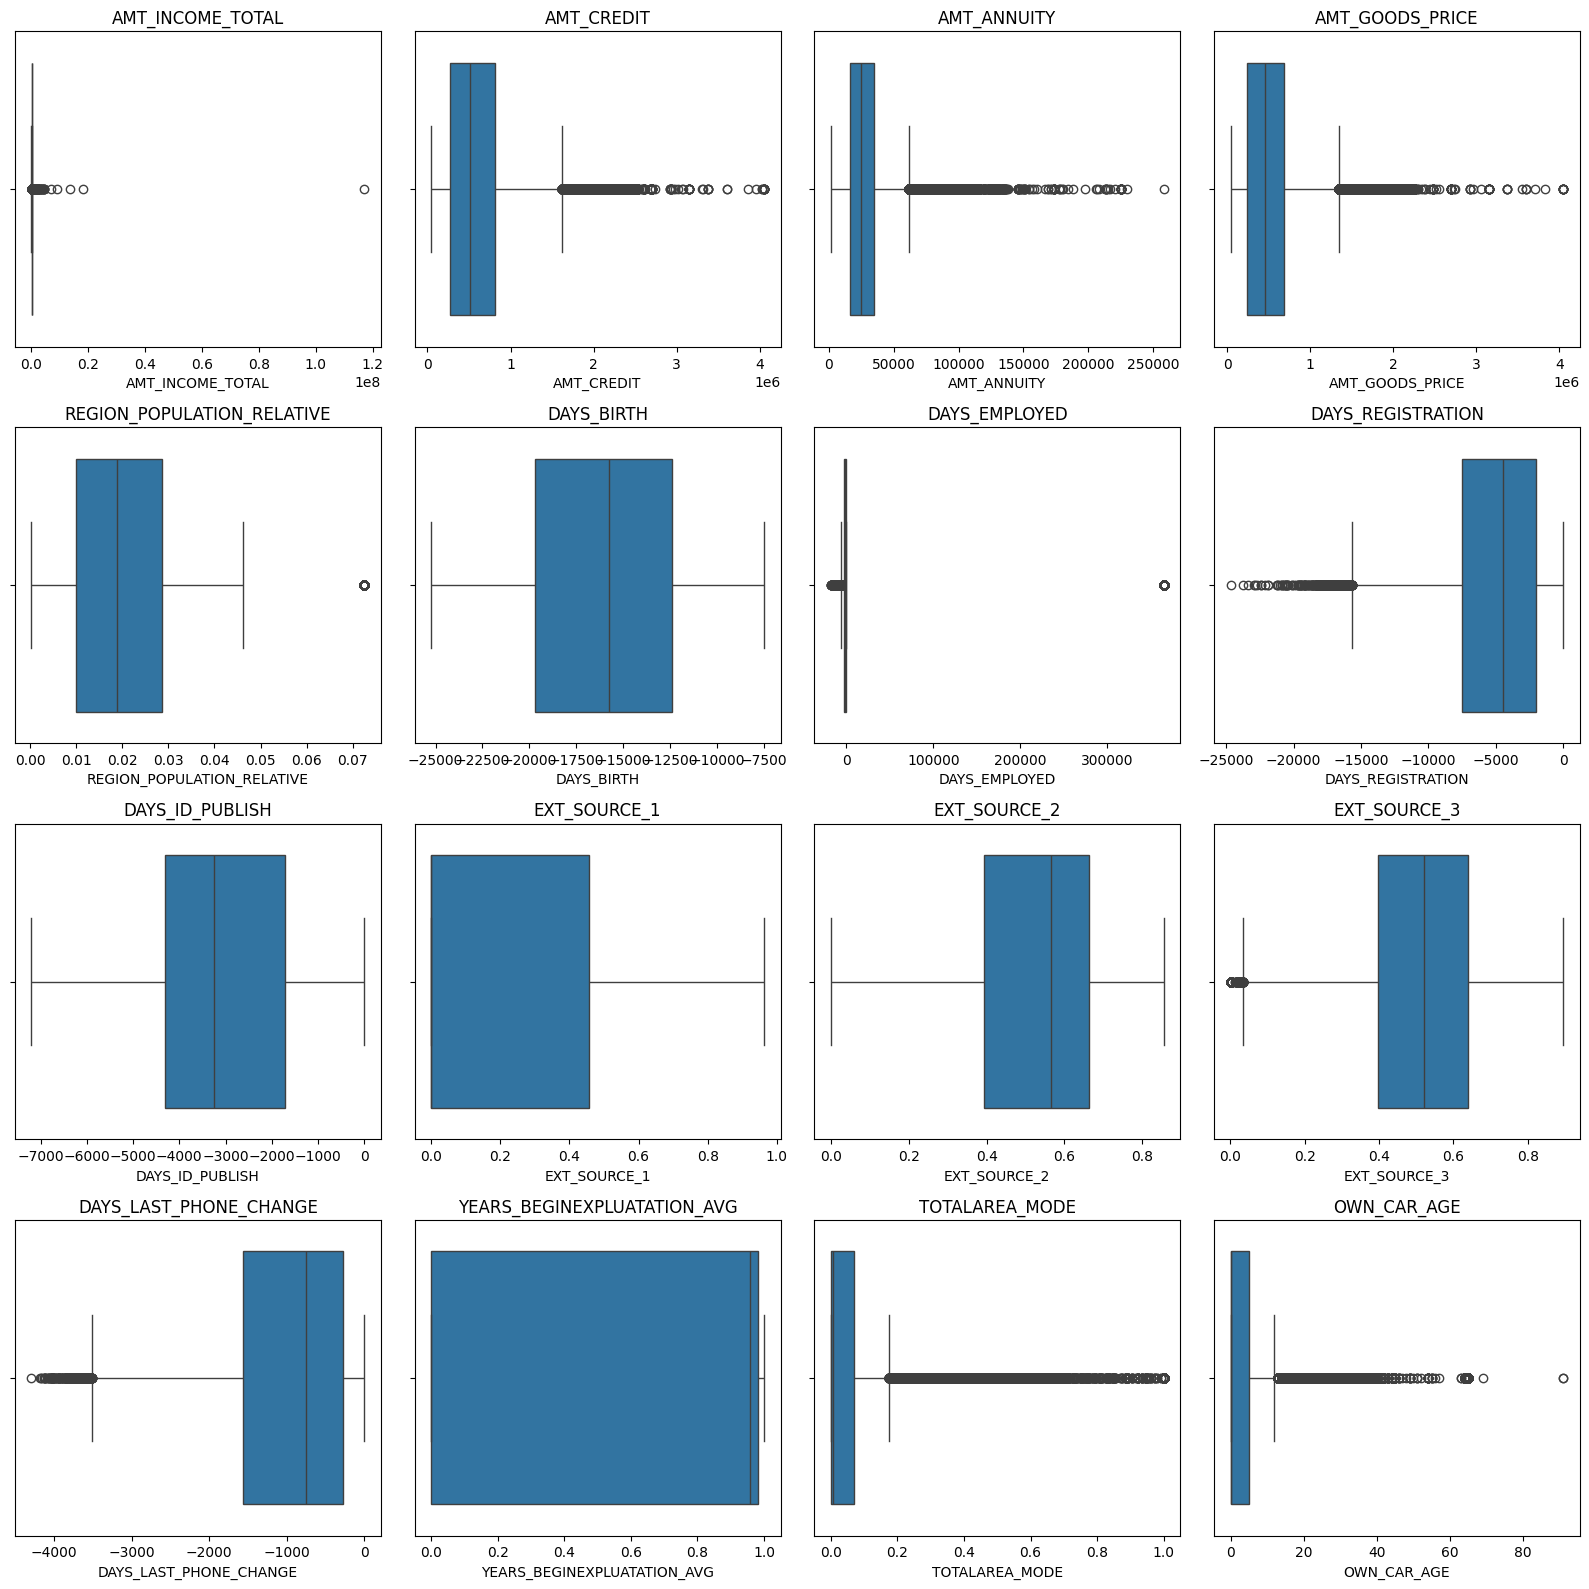

In [32]:
fig, axes= plt.subplots(nrows=4, ncols=4, figsize=(16,16))
axes = axes.flatten()

for i, col in enumerate(col_outlier):
  sns.boxplot(x=numeric[col], ax=axes[i])
  axes[i].set_title(col)

plt.tight_layout()
plt.show()

**[AMT_INCOME_TOTAL]**

Dropped one record where the reported income exceeded 20 million, as it was considered unrealsitic in our data.

In [33]:
fill_df[fill_df["AMT_INCOME_TOTAL"]>20000000]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,TOTALAREA_MODE,OWN_CAR_AGE
12840,114967,1,Cash loans,F,0,1,1,117000000.0,562491.0,26194.5,...,0.0,0.0,0.0,0.0,1.0,0.460809,0.1031,0.9791,0.0715,0.0


In [34]:
fill_df = fill_df[fill_df["AMT_INCOME_TOTAL"]<20000000].copy()

**[DAYS_EMPLOYED]**
- The value 365243 is known to be a special code representing unemployment.
- We replaced this value with 0 and created.

In [35]:
fill_df["DAYS_EMPLOYED"].describe()["max"]

np.float64(365243.0)

In [36]:
fill_df["DAYS_EMPLOYED"] = fill_df["DAYS_EMPLOYED"].replace(365243,0)

In [37]:
fill_df["FLAG_UNEMPLOYED"] = (fill_df["DAYS_EMPLOYED"] == 0).astype(int)

**[REGION_POPULATION_RELATIVE] + [OWN CAR AGE]**

We did not remove or replace these values, since the observed extreme values appeared reasonable.

In [38]:
fill_df["REGION_POPULATION_RELATIVE"].describe()["max"]

np.float64(0.072508)

In [39]:
fill_df["OWN_CAR_AGE"].describe()["max"]

np.float64(91.0)

### 1.3.3. Domain Features

Created Business meaningful features to enhance model's predictive performance.

**[Debt to Income (DTI)]**

- Represents the ratio of a client's total debt to their income.
- A higher DTI indicates that the client has applied for a loan amount that is high relative to their income.

**[Annuity Income Ratio]**

- Represents the proportion of a client's income that is spent on loan payment.
- A higher ratio indicates that a larger portion of the client's income is needed to pay the loan.

**[Credit Good Difference]**
- Represents the difference between the total credit amount requested and the price of the goods the loan is intended for.
- A higher positive value may indicate that the client borrowed more than the actual price of the goods.

**[Credit Term]**
- Represents the number of terms the client needs to repay the loan.
- A higher credit term can reflect the client's repayment capacity.


In [40]:
fill_df["DTI"] = fill_df["AMT_CREDIT"] / fill_df["AMT_INCOME_TOTAL"]
fill_df["ANNUITY_INCOME_RATIO"] = fill_df["AMT_ANNUITY"] / fill_df["AMT_INCOME_TOTAL"]
fill_df["CREDIT_GOODS_DIFF"] = fill_df["AMT_CREDIT"] - fill_df["AMT_GOODS_PRICE"]
fill_df["CREDIT_TERM"] = fill_df["AMT_ANNUITY"] / fill_df["AMT_CREDIT"]

## 1.4 Feature Selection

Examined correlations among features to remove highly collinear variables and select only relevant features for model training.

In [41]:
select_df = fill_df.copy()

### 1.4.1. High Correlation within Features

Our Strategy:

To prevent multicollinearity, we examined features with a correlation over 0.7 and decided which features to drop based on redundancy and interpretability.




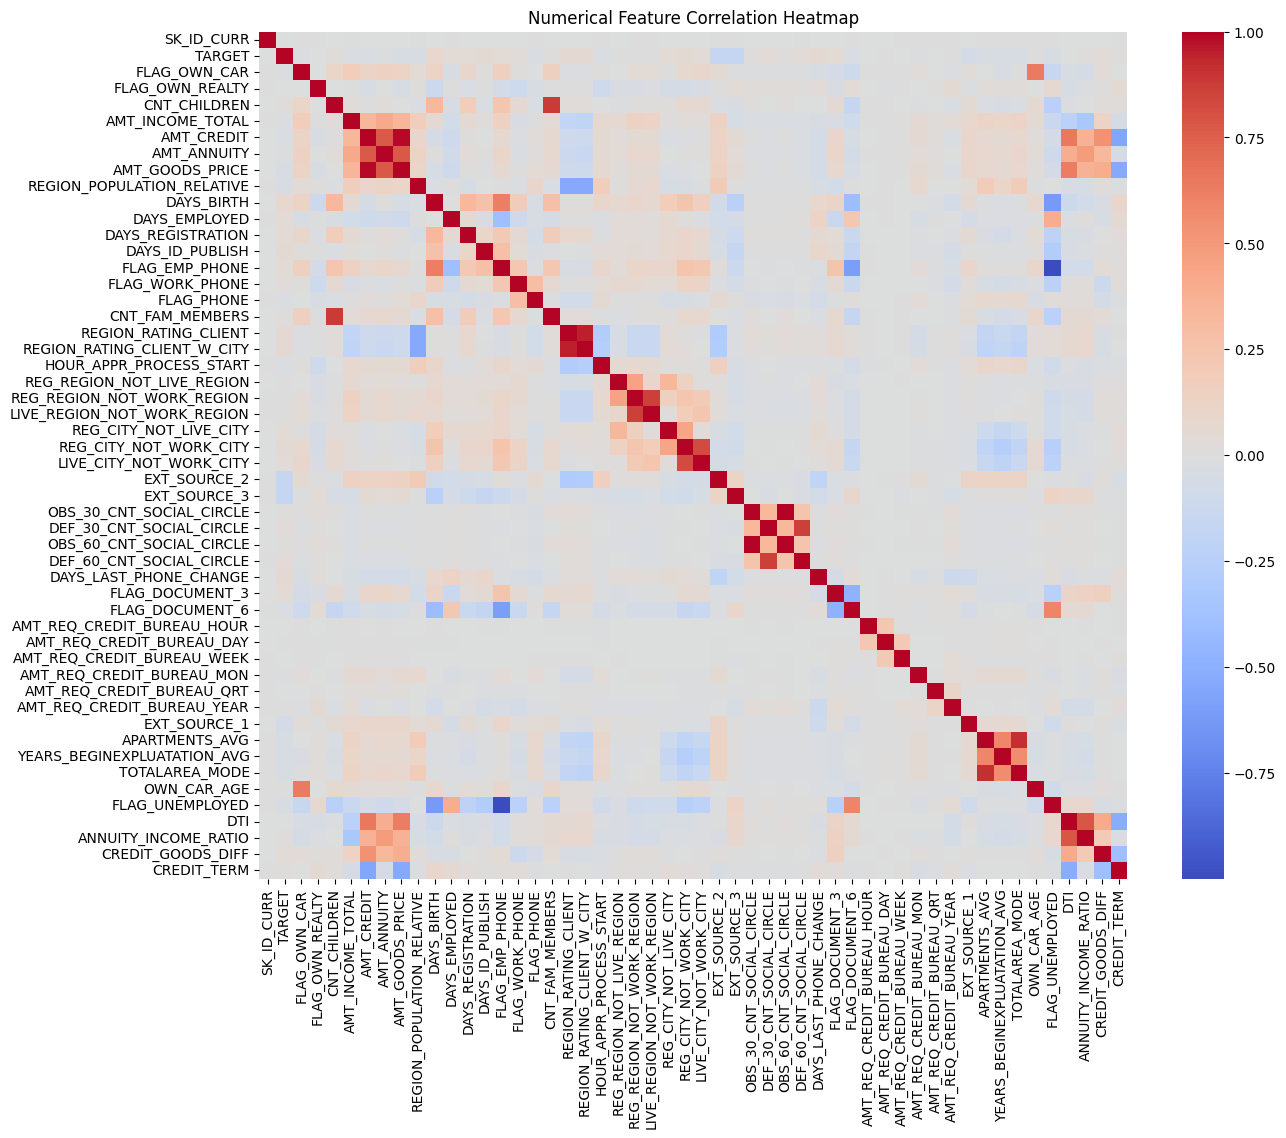

In [42]:
numeric = select_df.select_dtypes(include=['int64', 'float64'])

num_matrix = numeric.corr()
plt.figure(figsize=(14, 11))
sns.heatmap(num_matrix, cmap='coolwarm')
plt.title("Numerical Feature Correlation Heatmap")
plt.show()

In [43]:
drop_corr = ["REGION_RATING_CLIENT", "OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","APARTMENTS_AVG", "FLAG_EMP_PHONE", "CNT_FAM_MEMBERS","AMT_GOODS_PRICE"]

In [44]:
after_corr = []
for c in select_df.columns:
  if c not in drop_corr:
    after_corr.append(c)

In [45]:
select_df = select_df[after_corr]

**[Decision]**
- We retained only one feature from each highly correlated pair, based on domain knowledge and its predictive power for default detection.

- Although AMT_ANNUITY and AMT_CREDIT showed high correlation, we kept both features as they provide similar yet complementary financial information.

- Dropped 7 columns.

# 2. Model & Method Selection

Compared **Random Forest** and **Light Gradient Boosting Machine** using 4 different methods to handle the imbalanced target.

- **Methods Tested:**
  - Hyperparameter (Random Forest: class_weight, Light GBM: is_unbalance)
  - SMOTE
  - RandomOverSampler
  - RandomUnderSampler

- Details are provided in "[[early_default_detection]_model_selection_and_baseline_results.ipynb]([early_default_application]_model_selection_and_baseline_results.ipynb)"


**[Results]**

Although a 1:1 ratio (50% no default, 50% default) may seem ideal, it distorts the data distribution.
- Tested different ratios using sampling_strategy to find a more realistic and effective balance.

| Model | Method | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- | ----- |
| RandomForest | class_weight | 0.534 | 0.001 | 0.002 |
|  | smote (0.3) | 0.490 | 0.001 | 0.003 |
|  | smote (0.5) | 0.399 | 0.003 | 0.005 |
|  | over (0.5) | 0.496 | 0.009 | 0.018 |
|  | over (0.7) | 0.457 | 0.011 | 0.021 |
|  | under (0.3) | 0.352 | 0.124 | 0.183 |
|  | under (0.5) | 0.255 | 0.317 | 0.283 |
|LGBM | is_unbalance | 0.171 | 0.670 | 0.272 |
|  | smotenc (0.3) | 0.478 | 0.028 | 0.052 |
|  | smotenc (0.5) | 0.438 | 0.029 | 0.054 |
|  | over (0.5) | 0.247 | 0.411 | 0.309 |
|  | over (0.7) | 0.207 | 0.533 | 0.298 |
|  | under (0.3) | 0.308 | 0.248 | 0.275 |
|  | under (0.5) | 0.236 | 0.430 | 0.305 |

**[Best Model]**

**LGBMClassifier with RandomOverSampler (sampling_strategy=0.5)**
- Although recall is one of the most important metrics for this project's default detecting model, this model provides the most balanced trade off between precision and recall, achieving the highest F1.
- Since further steps involve feature selection based on feature importance and hyperparameter tuning, this balanced model serves as a more reliable foundation for the next steps.

# 3. Selected Model: LGBM with RandomOverSampler (sampling_strategy=0.5)

Examined the selected model in more detail and upgraded it to achieve better predictive performance.

- **LabelEncoder()**
  - LabelEncoder was used to convert each category into a numerical value within a single column.

- **categorical_feature**
  - This parameter was set so that LGBMClassifier can automatically handle categorical features.

- **StratifiedKFold**
  - Ensured that each fold preserved the same class distribution.
  - This helped to prevent small biases and provided a more stable and reliable model evaluation.

In [46]:
X = select_df.drop(columns=["TARGET","SK_ID_CURR"])
y = select_df['TARGET']

X_l = X.copy()
cat = X_l.select_dtypes(include=["object"]).columns
cat_idx = [X_l.columns.get_loc(c) for c in cat]
for c in cat:
  X_l[c] = LabelEncoder().fit_transform(X[c])

X_train, X_test, y_train, y_test = train_test_split(X_l, y, test_size=0.2, random_state=42, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [47]:
sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature = cat_idx, random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

y_proba_over = cross_val_predict(pipe, X_train,y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

In [48]:
pipe

Pipeline(steps=[('sample',
                 RandomOverSampler(random_state=42, sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(categorical_feature=[0, 1, 8, 9, 10, 11, 12, 20,
                                                     22, 30],
                                random_state=42))])

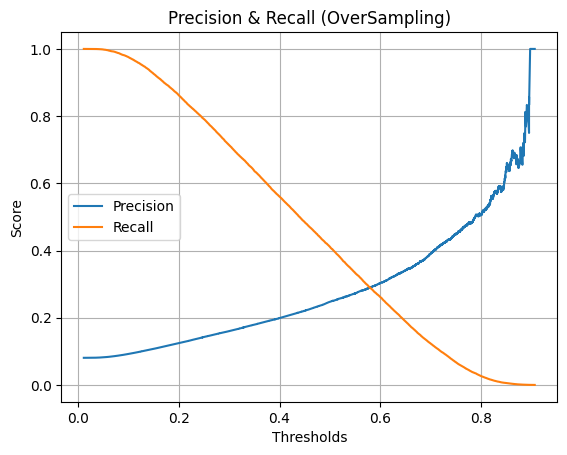

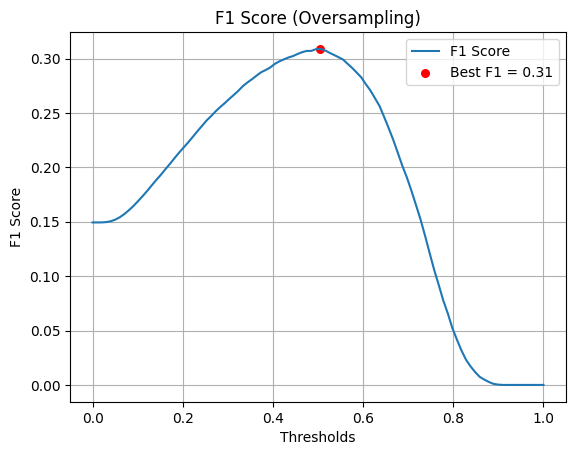

In [49]:
precision, recall, thresholds = precision_recall_curve(y_train, y_proba_over)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Thresholds")
plt.ylabel("Score")
plt.title("Precision & Recall (OverSampling)")
plt.legend()
plt.grid()
plt.show()

f1_th = np.linspace(0,1,100)
f1_scores=[]
for th in f1_th:
  y_pred_over = (y_proba_over > th).astype(int)
  f1_scores.append(f1_score(y_train,y_pred_over))

best_idx = np.argmax(f1_scores)
best_th = f1_th[best_idx]
best_f1 = f1_scores[best_idx]

plt.plot(f1_th, f1_scores, label="F1 Score")
plt.scatter(best_th, best_f1, s=30, color="red", label=f"Best F1 = {best_f1:.2f}")
plt.xlabel("Thresholds")
plt.ylabel("F1 Score")
plt.title("F1 Score (Oversampling)")
plt.legend()
plt.grid()
plt.show()

In [50]:
print(f"Best F1 Threshold: {best_th:.2f}")
y_pred_over = (y_proba_over > best_th).astype(int)
accuracy = accuracy_score(y_train, y_pred_over)
precision = precision_score(y_train, y_pred_over)
recall = recall_score(y_train, y_pred_over)
f1 = f1_score(y_train, y_pred_over)
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Best F1 Threshold: 0.51
Accuracy: 85.42%, Precision: 25.02%, recall: 40.36%, f1: 30.89%


**[Basic Model Performance]**

Precision: 25.02% | Recall: 40.36% | F1 Score: 30.89%

- These results represent the basic performance of thee selected model.
- We will enhance this model through feature selection and hyperparameter tuning to improve both performance and stability.


## 3.2. Improving the Selected Model

Further improving the selected LGBMClassifier model through tuning and feature selection.

### 3.2.1. Feature Selection Based on Importance

Drop the less relevant features using feature importance scores.

Our Strategy:

- Test different importance cutoffs below 0.005 to determine the optimal threshold.

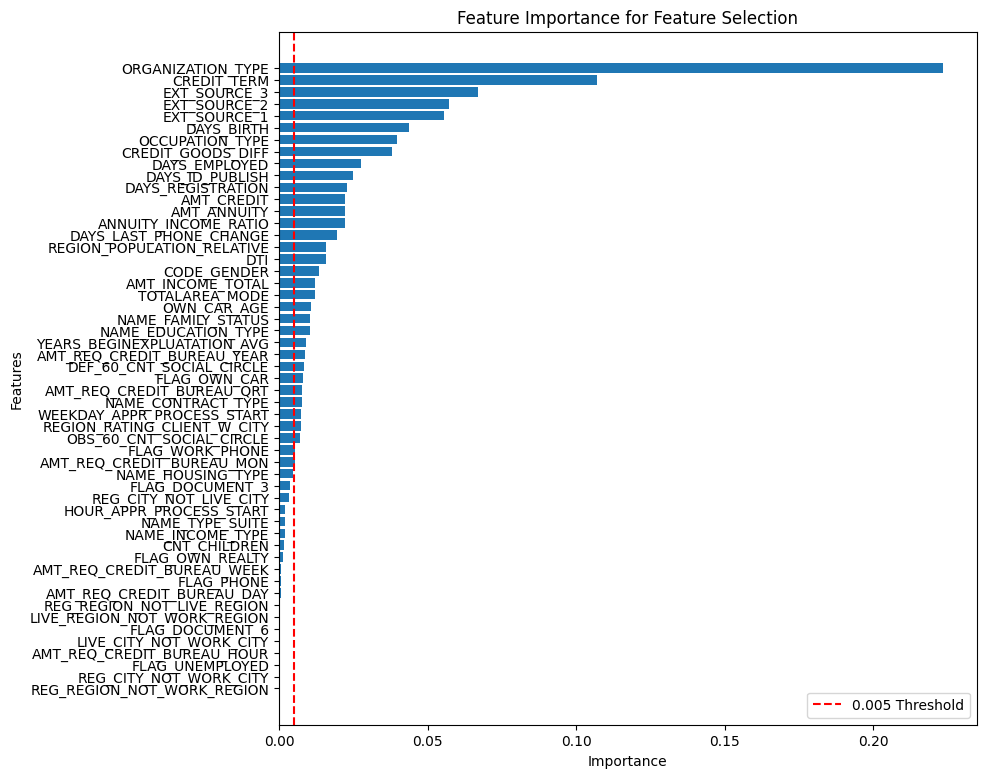

In [51]:
sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_over, y_train_over = sample.fit_resample(X_train, y_train)
lgbm = LGBMClassifier(categorical_feature=cat_idx, random_state=42, verbose=-1)
lgbm.fit(X_train_over, y_train_over)
lgbm_importance = lgbm.feature_importances_

feature_importances = pd.DataFrame({"Feature":X_train.columns, "Importance": lgbm_importance / lgbm_importance.sum()})
sorted_feature = feature_importances.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(9,9))
plt.barh(sorted_feature["Feature"], sorted_feature["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Feature Selection")
plt.axvline(x=0.005, color='red', linestyle='--', label='0.005 Threshold')
plt.legend()
plt.show()

In [52]:
over_005 = feature_importances[feature_importances["Importance"]>=0.005]["Feature"].to_list()

X_im = X[over_005].copy()
cat = X_im.select_dtypes(include=["object"]).columns
cat_idx = [X_im.columns.get_loc(c) for c in cat]
for c in cat:
  X_im[c] = LabelEncoder().fit_transform(X_im[c])

X_train_im, X_test_im, y_train, y_test = train_test_split(X_im, y, test_size=0.2, random_state=42, stratify=y)

sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature=cat_idx,random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

y_proba_im = cross_val_predict(pipe, X_train_im,y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

f1_th = np.linspace(0,1,100)
f1_scores=[]
for th in f1_th:
  y_pred_im = (y_proba_im > th).astype(int)
  f1_scores.append(f1_score(y_train,y_pred_im))

best_idx = np.argmax(f1_scores)
best_th = f1_th[best_idx]

y_pred_im = (y_proba_im > best_th).astype(int)
accuracy = accuracy_score(y_train, y_pred_im)
precision = precision_score(y_train, y_pred_im)
recall = recall_score(y_train, y_pred_im)
f1 = f1_score(y_train, y_pred_im)
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Accuracy: 84.82%, Precision: 24.40%, recall: 41.97%, f1: 30.86%


**[Results]**

| Cutoff | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- |
| Basic (no cutoff) | 25.02% | 40.36% | 30.89% |
| 0.005 | 24.40% | 41.97% | 30.86% |
| 0.004 | 23.28% | 44.77% | 30.63% |
| 0.003 | 24.27% | 41.66% | 30.67% |
| 0.002 | 24.84% | 40.13% | 30.69% |
| 0.001 | 24.92% | 40.16% | 30.76% |
| 0.0003 | 24.97% | 40.24% | 30.82% |

**Selected Cutoff: 0.005**
- Selected 0.005 cutoff since it improves recall compared to the basic model, while the F1 score remains nearly unchanged.
- As hyperparameter tuning is not yet performed and this project aims to build an initial filtering model using only application dataset, fewer features are preferred at this stage.

### 3.2.2. Hyperparameter Tuning

Optimized model hyperparameters using RandomizedSearchCV to enhance predictive performance while preventing overfitting.

In [53]:
params = {"model__max_depth":[-1,10,20,30,40],
          "model__n_estimators":[100,200,300],
          "model__num_leaves":[20,30,40,50],
          "model__learning_rate":[0.02,0.05,0.01],
          "model__colsample_bytree":[0.5,0.6,0.8,1.0]}

sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature=cat_idx, random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

rs = RandomizedSearchCV(pipe, param_distributions=params, n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rs.fit(X_train_im, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('sample',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy=0.5)),
                                             ('model',
                                              LGBMClassifier(categorical_feature=[0,
                                                                                  1,
                                                                                  6,
                                                                                  7,
                                                                                  14,
                                                                                  16,
                                                                                  17],
                                                             random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.5, 0.6,
                                                                    0.8, 1.0],
                                        'model__learning_rate': [0.02, 0.05,
                                                                 0.01],
                                        'model__max_depth': [-1, 10, 20, 30,
                                                             40],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__num_leaves': [20, 30, 40, 50]},
                   random_state=42, scoring='f1')

In [54]:
best_pipe = rs.best_estimator_

In [55]:
y_proba_par_train = cross_val_predict(best_pipe, X_train_im, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

thresholds = np.linspace(0, 1, 100)

f1_scores = []
for threshold in thresholds:
    y_pred_par_train = (y_proba_par_train > threshold).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_par_train))

best_th = thresholds[np.argmax(f1_scores)]
y_pred_par_train = (y_proba_par_train > best_th).astype(int)

accuracy = accuracy_score(y_train, y_pred_par_train)
precision = precision_score(y_train, y_pred_par_train)
recall = recall_score(y_train, y_pred_par_train)
f1 = f1_score(y_train, y_pred_par_train)

print(f"Best Threshold: {best_th:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Best Threshold: 0.4949
Accuracy: 84.93%, Precision: 24.64%, recall: 42.10%, f1: 31.09%


**[Adjusting Thresholds]**

To Check whether the tuned model still performs better than the basic model and to explore how high recall can be set while maintaining a balanced performance.

In [56]:
thresholds = np.linspace(0, 1, 100)

f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_par_train = (y_proba_par_train > threshold).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_par_train))
    precisions.append(precision_score(y_train, y_pred_par_train, zero_division = 0))
    recalls.append(recall_score(y_train, y_pred_par_train, zero_division = 0))


f1_scores = np.array(f1_scores)
precisions = np.array(precisions)
recalls = np.array(recalls)

target_recall = 0.45
best_idx = np.argmin(np.abs(recalls - target_recall))
best_th_target = thresholds[best_idx]

y_pred_par_train = (y_proba_par_train > best_th_target).astype(int)

accuracy = accuracy_score(y_train, y_pred_par_train)
precision = precision_score(y_train, y_pred_par_train)
recall = recall_score(y_train, y_pred_par_train)
f1 = f1_score(y_train, y_pred_par_train)

print(f"Best Threshold: {best_th_target:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1: {f1*100:.2f}%")

Best Threshold: 0.4747
Accuracy: 83.69%, Precision: 23.47%, Recall: 45.15%, F1: 30.89%


### 3.2.3 Test Result

Evaluated the final performance of the model trained only on the recent application data and check for potential overfitting.

In [57]:
y_proba_test = best_pipe.predict_proba(X_test_im)[:,1]

best_th_train = best_th_target #Select original (best_th) or adjusted (best_th_target)

y_pred_test = (y_proba_test > best_th_train).astype(int)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"Best Threshold: {best_th_train:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1: {f1*100:.2f}%")

Best Threshold: 0.4747
Accuracy: 83.81%, Precision: 23.66%, Recall: 45.20%, F1: 31.06%


### **[LGBM Final Results]**

| Model | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- |
| Basic | 25.02% | 40.36% | 30.89% |
| 0.005 cutoff | 24.40% | 41.97% | 30.86% |
| Tuned | 24.64% | 42.10% | 31.09% |
| Adjusted (recall 45%)| 23.47% | 45.15% | 30.89% |
|  | Test Score |
| Without Adjustment | 24.79% | 41.95% | 31.17% |
| With Adjustmet | 23.66% | 45.20% | 31.06% |

- Adjusting the decision threshold to achieve higher recall (45%) led to a minor drop in F1, but better aligns with the project goal of detecting defaults.
- The threshold adjusted model maintained a similar F1 score to the basic and 0.005 cutoff models.
- Test results show slightly improved F1 and recall compared to training results, indicating the model generalizes well without signs of overfitting.


# 4. Merged Data (Recent + Past)
Merged Current and Past application data and see if the past data enhances the model performance.


## 4.1. Recent (Current) Application Data

This dataset represents the final version used for modeling recent applications.

In [58]:
curr = select_df.copy()

## 4.2. Past Application Data
Preprocessing the past application data before merging with the current data.

### 4.2.1. Data Basic

Checked past application dataset structure and numerber of missing/duplicate records to understand overall data quality.

In [ ]:
past = pd.read_csv("../data/application/previous_application.csv")

In [60]:
past.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [61]:
print(f"number of columns including null: {(past.isna().sum()>0).sum()}")

number of columns including null: 16


In [62]:
print(f"number of duplicated records: {past.duplicated().sum()}")

number of duplicated records: 0


**[Data Basics]**

- The dataset contains 1670214 rows with 37 columns.
- SK_ID_CURR is used to match the data with the current application.
- 16 columns have missing values.
- There are no duplicate records in the dataset.

### 4.2.2. Exploratory Data Analysis (EDA)

Checked the missingness patterns.

#### 4.2.2.1. Missing Values

Visualized missing rates across features containing null values to plan imputation (drop or fill).

Our Strategy:

(Same rules applied as in the recent application dataset)

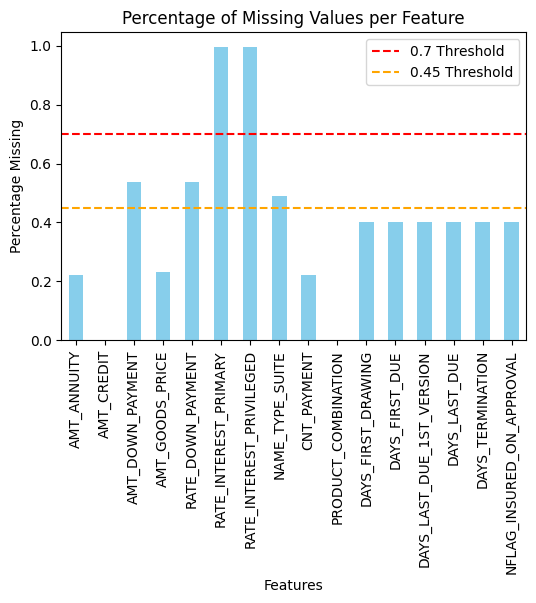

In [63]:
missing_pct = past.isnull().mean()
col_missing = missing_pct[missing_pct>0].index
data_missing = missing_pct[col_missing]

data_missing.plot(kind='bar', figsize=(6, 4), color='skyblue')
plt.title("Percentage of Missing Values per Feature")
plt.xlabel("Features")
plt.ylabel("Percentage Missing")

plt.axhline(y=0.7, color='r', linestyle='--', label='0.7 Threshold')
plt.axhline(y=0.45, color='orange', linestyle='--', label='0.45 Threshold')
plt.legend()
plt.show()

In [64]:
missing_delete = ["RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED", "SK_ID_PREV", "DAYS_LAST_DUE_1ST_VERSION"]
after_miss =[]
for c in past.columns:
  if c not in missing_delete:
    after_miss.append(c)

In [65]:
past = past[after_miss]

In [66]:
len(after_miss)

33

**[Decisions]**

Based on the visualization and our defined thresholds (45%, 70%):
* **Retained (<=45%)**: 33 columns were kept
* **Dropped (>=70%)**: 2 columns were dropped due to insufficient data
* **Revewied (45-70%)**:
  * (**Domain Knowledge**) Down Payment related features and Name Type Suite were retained despite the high missing rate, as they are likely to be important for prediction.

Additional Decisions:

* Dropped SK_ID_PREV since it is unnecessary for this project, which focuses only on the application dataset.

* Dropped Days_LAST_DUE_1st_Version since its final version is already included.



### 4.2.3. Feature Engineering

Handling outliers, creating domain based features to improve model predictive power and aggregating data by SK_ID_CURR to prepare for merging with the current application dataset.

#### 4.2.3.1. Outliers

Identify outliers from selected numerical features and decide whether to remove or modify them.

Our Strategy:

(Same rules applied as in the recent application dataset)

In [67]:
numeric = past.select_dtypes(include=['int64', 'float64'])

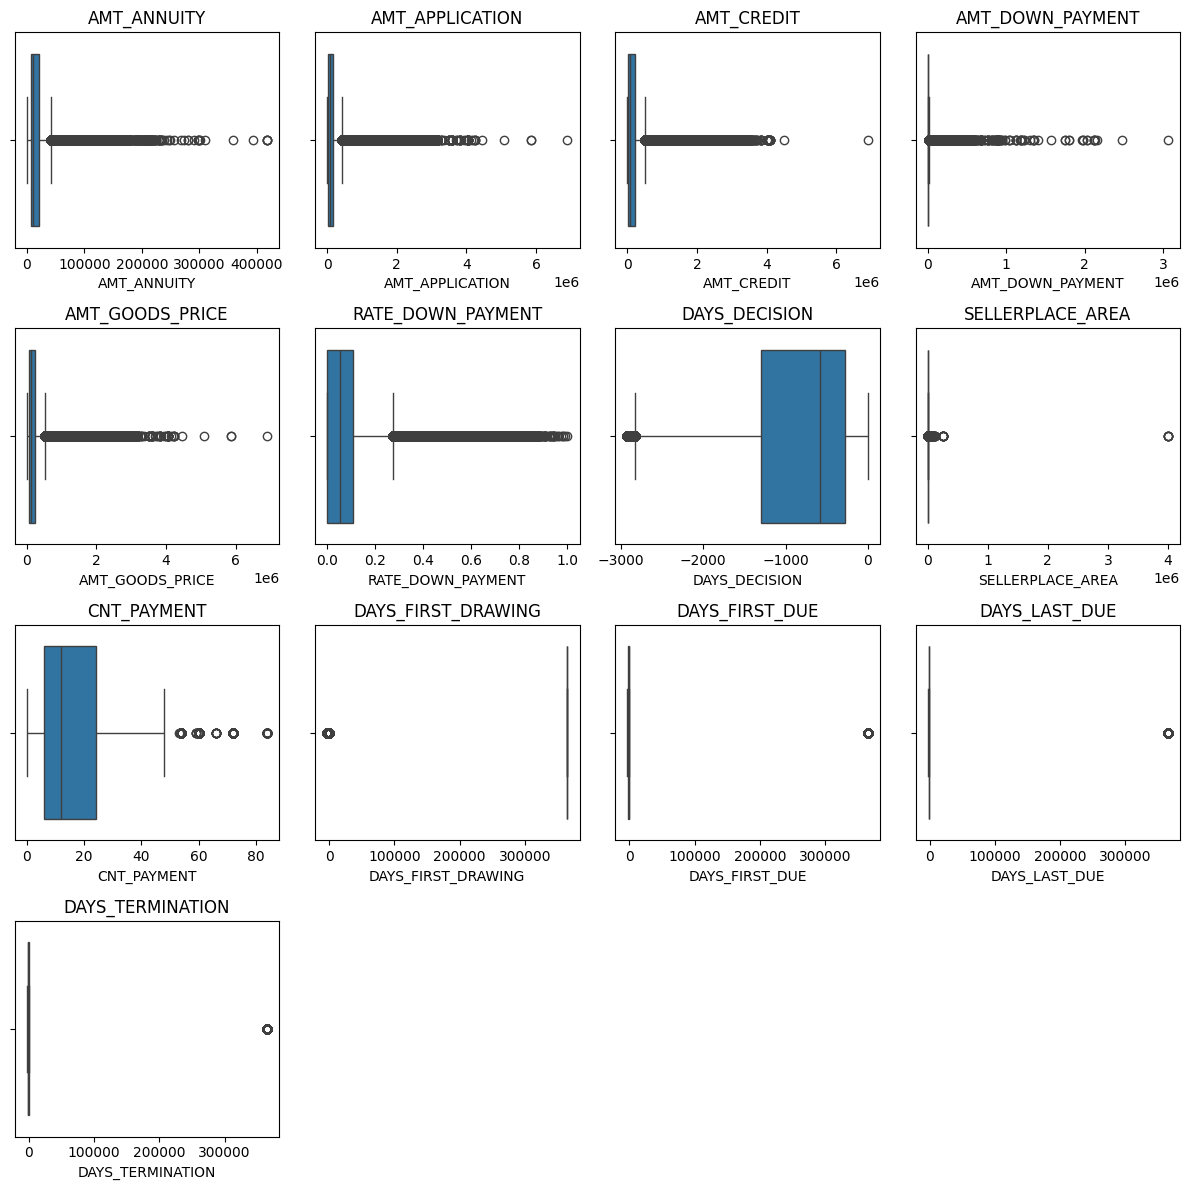

In [68]:
col_outlier = ["AMT_ANNUITY","AMT_APPLICATION", "AMT_CREDIT", "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_DOWN_PAYMENT",
               "DAYS_DECISION",'SELLERPLACE_AREA', "CNT_PAYMENT", "DAYS_FIRST_DRAWING","DAYS_FIRST_DUE",
               "DAYS_LAST_DUE","DAYS_TERMINATION"]

fig, axes= plt.subplots(nrows=4, ncols=4, figsize=(12,12))
axes = axes.flatten()

for i, col in enumerate(col_outlier):
  sns.boxplot(x=numeric[col], ax=axes[i])
  axes[i].set_title(col)

for j in range(len(col_outlier), len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**[SELLERPLACE_AREA]**

- Replaced -1 with 0, as it likely represents missing values.
- Removed 5 records with value equal to 4000000 which is considered unrealistic.
- For consistency, SK_ID_CURR 22816 and 390387 should be also removed from the current dataset, as they don't have any other records.

In [69]:
past["SELLERPLACE_AREA"] = past["SELLERPLACE_AREA"].replace(-1,0)

In [70]:
past = past[past["SELLERPLACE_AREA"]<4000000].copy()

**[Days Columns]**

The value 365243 represents a missing code, so it was replaced with NaN and left unfilled, as there was no reliable value to replace it with and LightGBM can handle missing values.

In [71]:
days = ["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE", "DAYS_LAST_DUE","DAYS_TERMINATION"]

In [72]:
for d in days:
  past[d] = past[d].replace(365243, np.nan)

#### 4.2.3.2 Domain Features

Create Business meaningful features using past application data to enhance model predictive performance.

**[Credit Good Difference]** and **[Credit Term]**
- Same as we created in Recent Application dataset.


**[Application Credit Ratio]**
- Represents how much of the requested loan was approved.

**[Payment Delay]**
- Represents the difference between the loan termination date and the last due date.

In [73]:
past["CREDIT_GOODS_DIFF"] = past["AMT_CREDIT"] - past["AMT_GOODS_PRICE"]
past["CREDIT_TERM"] = past["AMT_ANNUITY"] / past["AMT_CREDIT"]
past["APP_CREDIT_RATIO"] = past["AMT_CREDIT"] / past["AMT_APPLICATION"]
past["PAY_DELAY"] = past["DAYS_TERMINATION"] - past["DAYS_LAST_DUE"]

#### 4.2.3.3 Aggregated Features

Aggregate the past records by SK_ID_CURR to properly merge them with the Recent Applicatio data.

- Numerical features were aggregated using mean, max, and min while categorical features were aggregated using mode.

- Created past_APP_COUNT to count the total number of past applications submitted by each client.

In [74]:
nums = list(past.iloc[:,1:].select_dtypes(include=["int64","float64"]).columns)
cats = list(past.iloc[:,1:].select_dtypes(include=["object"]).columns)

In [75]:
num_agg = (past[nums + ["SK_ID_CURR"]].groupby("SK_ID_CURR").agg(["mean","max","min"]).reset_index())
num_agg.columns = [col[0] if col[0]=="SK_ID_CURR" else f"past_{col[0]}_{col[1]}" for col in num_agg.columns.values]

cat_agg = (past[cats + ["SK_ID_CURR"]].groupby("SK_ID_CURR").agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index())
cat_agg.columns = [col if col == "SK_ID_CURR" else f"past_{col}" for col in cat_agg.columns]

past_count = past.groupby("SK_ID_CURR").size().reset_index(name="past_APP_COUNT")

In [76]:
past_agg = (num_agg.merge(cat_agg, on="SK_ID_CURR", how="left").merge(past_count, on="SK_ID_CURR",how="left"))

## 4.3 Merged Data (Recent + Past Application)

Merged Recent and Past Application data based on the recent application dataset using SK_ID_CURR as the key, with a left join.

In [ ]:
merged = curr.merge(past_agg, on="SK_ID_CURR",how="left")

Due to outlier of Sellerplace Area, we dropped two SK_ID_CURR: 228186 and 390387

In [78]:
merged = merged[~merged["SK_ID_CURR"].isin([228186,390387])]

In [79]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307508 entries, 0 to 307509
Columns: 132 entries, SK_ID_CURR to past_APP_COUNT
dtypes: float64(85), int64(21), object(26)
memory usage: 312.0+ MB


**[Merged Data Basic]**
- The dataset contains 307509 rows with 132 columns.

### 4.3.1. Null Imputation

Our Strategy:
- For the 16454 clients without past records, missing numerical features were filled with 0, and categorical features were filled with No_Past.
- For clients with past records, missing numerical features were imputed with the mean, and categorical features were imputed with the mode.

- Days related features were not filled since they were intended to remain as NaN.

In [80]:
merged["IS_NEW_CLIENT"] = merged["past_APP_COUNT"].isnull().astype(int)

no_fill = ["DAYS_FIRST_DRAWING","DAYS_FIRST_DUE", "DAYS_LAST_DUE","DAYS_TERMINATION"]

past_cols = [c for c in merged.columns if c.startswith("past_")]
past_num = [c for c in past_cols if merged[c].dtype != "object"]
past_cat = [c for c in past_cols if merged[c].dtype == "object"]

for c in past_num:
  if any(c.startswith(f"past_{base}_") for base in no_fill):
    continue
  num_mean = merged.loc[merged["IS_NEW_CLIENT"]==0, c].mean()
  merged.loc[merged["IS_NEW_CLIENT"]==0, c] = merged.loc[merged["IS_NEW_CLIENT"]==0, c].fillna(num_mean)
  merged.loc[merged["IS_NEW_CLIENT"]==1, c] = merged.loc[merged["IS_NEW_CLIENT"]==1, c].fillna(0)

for c in past_cat:
  cat_fill = "Missing"
  cat_mode = merged.loc[merged["IS_NEW_CLIENT"]==0, c].mode()
  if not cat_mode.empty:
    cat_fill = cat_mode.iloc[0]
  merged.loc[merged["IS_NEW_CLIENT"]==0, c] = merged.loc[merged["IS_NEW_CLIENT"]==0, c].fillna(cat_fill)
  merged.loc[merged["IS_NEW_CLIENT"]==1, c] = merged.loc[merged["IS_NEW_CLIENT"]==1, c].fillna("No_Past")

### 4.3.2. High Correlation within Features

(Same rules applied as in the recent application dataset)

In [ ]:
merge_num_high_corr = ["past_CREDIT_TERM_min","past_AMT_DOWN_PAYMENT_max","past_AMT_DOWN_PAYMENT_min","past_RATE_DOWN_PAYMENT_min",
                       "past_RATE_DOWN_PAYMENT_max","past_APP_CREDIT_RATIO_max","past_SELLERPLACE_AREA_min","past_DAYS_FIRST_DUE_min",
                       "past_HOUR_APPR_PROCESS_START_min","past_PAY_DELAY_max","past_NFLAG_LAST_APPL_IN_DAY_mean","past_APP_CREDIT_RATIO_min",
                       "past_PAY_DELAY_min","past_AMT_ANNUITY_max","past_DAYS_FIRST_DRAWING_min","past_AMT_APPLICATION_max","past_DAYS_TERMINATION_max",
                       "past_DAYS_TERMINATION_mean","past_AMT_GOODS_PRICE_min","past_CREDIT_TERM_max","past_CREDIT_GOODS_DIFF_max",
                       "past_AMT_APPLICATION_min","past_CREDIT_GOODS_DIFF_min","past_AMT_GOODS_PRICE_max",
                       "past_DAYS_FIRST_DRAWING_max","past_NFLAG_LAST_APPL_IN_DAY_max","past_CNT_PAYMENT_max","past_AMT_ANNUITY_min",
                       "past_APP_CREDIT_RATIO_mean","past_SELLERPLACE_AREA_max","past_DAYS_TERMINATION_min","past_HOUR_APPR_PROCESS_START_max",
                       "past_DAYS_LAST_DUE_min","past_NFLAG_INSURED_ON_APPROVAL_max","past_NFLAG_LAST_APPL_IN_DAY_min",
                       "past_NFLAG_INSURED_ON_APPROVAL_min","past_DAYS_DECISION_min","past_DAYS_LAST_DUE_max","past_DAYS_FIRST_DUE_max",
                       "past_DAYS_DECISION_max","past_DAYS_DECISION_max","past_AMT_CREDIT_max","past_AMT_APPLICATION_mean","past_AMT_GOODS_PRICE_mean",
                       "past_DAYS_FIRST_DUE_mean","past_DAYS_LAST_DUE_mean"]

In [82]:
after_num_high_corr = []
for c in merged.columns:
  if c not in merge_num_high_corr:
    after_num_high_corr.append(c)

In [83]:
merged = merged[after_num_high_corr]

**[Decision]**

- We retained only one feature from each highly correlated pair (over 0.7), based on domain knowledge and its predictive power for default detection.

- When the same feature with different aggregation functions had high correlation, we mainly kept the mean to maintain the overall distribution.

- Some features, including those from the recent application dataset, were retained to maintain consistency and because they may be important for detecting defaults.

- Dropped 46 columns.

# 5. Merged Modeling

Evaluated the previously selected model, LGBMClassifier with RandomOverSampler (sampling_strategy = 0.5), on the merged dataset to assess how adding past application data improves prediction performance and stability.

In [ ]:
X = merged.drop(columns=["TARGET","SK_ID_CURR"])
y = merged["TARGET"]

X_l = X.copy()
cat = X_l.select_dtypes(include=["object"]).columns
cat_idx = [X_l.columns.get_loc(c) for c in cat]
for c in cat:
  X_l[c] = LabelEncoder().fit_transform(X[c])

X_train, X_test, y_train, y_test = train_test_split(X_l, y, test_size=0.2, random_state=42, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [85]:
sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature = cat_idx, random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

y_proba_over = cross_val_predict(pipe, X_train,y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

In [86]:
pipe

Pipeline(steps=[('sample',
                 RandomOverSampler(random_state=42, sampling_strategy=0.5)),
                ('model',
                 LGBMClassifier(categorical_feature=[0, 1, 8, 9, 10, 11, 12, 20,
                                                     22, 30, 68, 69, 70, 71, 72,
                                                     73, 74, 75, 76, 77, 78, 79,
                                                     80, 81, 82, 83],
                                random_state=42))])

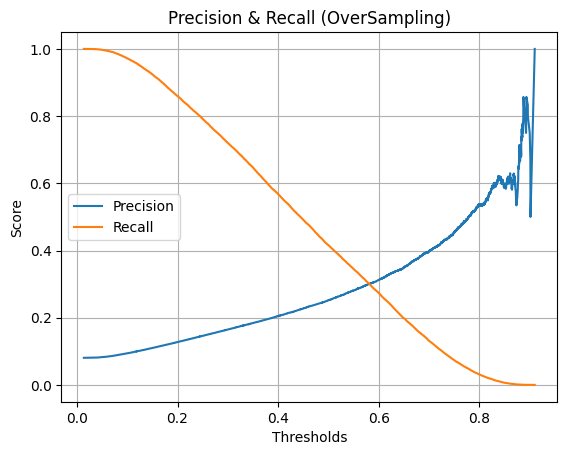

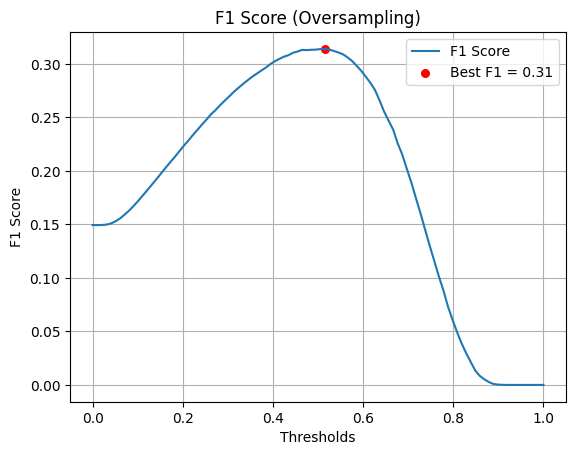

In [87]:
precision, recall, thresholds = precision_recall_curve(y_train, y_proba_over)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Thresholds")
plt.ylabel("Score")
plt.title("Precision & Recall (OverSampling)")
plt.legend()
plt.grid()
plt.show()

f1_th = np.linspace(0,1,100)
f1_scores=[]
for th in f1_th:
  y_pred_over = (y_proba_over > th).astype(int)
  f1_scores.append(f1_score(y_train,y_pred_over))

best_idx = np.argmax(f1_scores)
best_th = f1_th[best_idx]
best_f1 = f1_scores[best_idx]

plt.plot(f1_th, f1_scores, label="F1 Score")
plt.scatter(best_th, best_f1, s=30, color="red", label=f"Best F1 = {best_f1:.2f}")
plt.xlabel("Thresholds")
plt.ylabel("F1 Score")
plt.title("F1 Score (Oversampling)")
plt.legend()
plt.grid()
plt.show()

In [88]:
print(f"Best F1 Threshold: {best_th:.2f}")
y_pred_over = (y_proba_over > best_th).astype(int)
accuracy = accuracy_score(y_train, y_pred_over)
precision = precision_score(y_train, y_pred_over)
recall = recall_score(y_train, y_pred_over)
f1 = f1_score(y_train, y_pred_over)
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Best F1 Threshold: 0.52
Accuracy: 86.07%, Precision: 26.07%, recall: 39.48%, f1: 31.40%


**[Basic Model Performance]**

Precision: 26.07% | Recall: 39.48% | F1 Score: 31.40%

- After adding past application data, compared to the basic recent only model, precision slightly increased while recall decreased marginally, resulting in a small improvement in F1 score.
- Although recall is our primary focus for this project, adding the past data seems to provide additional information that stabilizes the model performance.

=> Next, the model will be enhanced through feature importance based selection and hyperparameter tuning to compare against the model trained only on the recent application data.

## 5.1. Improving the Model

### 5.1.1 Feature Selection Based on Importance
(Same rules applied as in the recent application dataset)


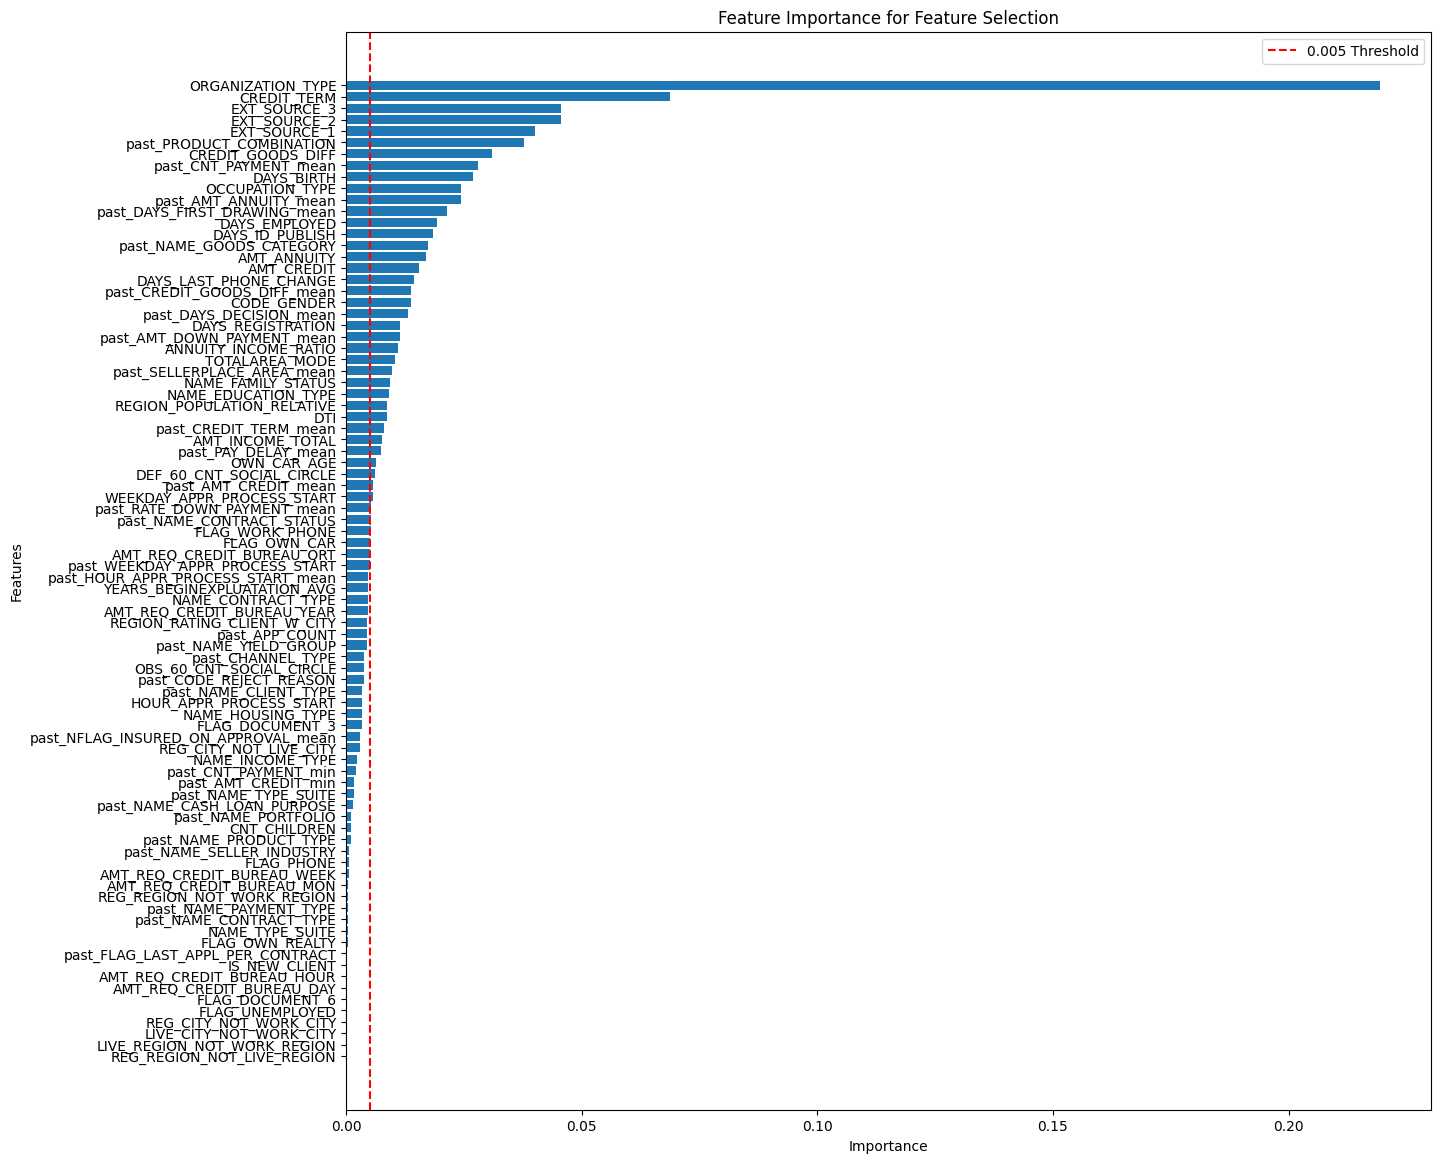

In [89]:
sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
X_train_over, y_train_over = sample.fit_resample(X_train, y_train)
lgbm = LGBMClassifier(categorical_feature=cat_idx, random_state=42, verbose=-1)
lgbm.fit(X_train_over, y_train_over)
lgbm_importance = lgbm.feature_importances_

feature_importances = pd.DataFrame({"Feature":X_train.columns, "Importance": lgbm_importance / lgbm_importance.sum()})
sorted_feature = feature_importances.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(14,14))
plt.barh(sorted_feature["Feature"], sorted_feature["Importance"])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Feature Selection")
plt.axvline(x=0.005, color='red', linestyle='--', label='0.005 Threshold')
plt.legend()
plt.show()

In [90]:
over_003 = feature_importances[feature_importances["Importance"]>=0.003]["Feature"].to_list()

X_im = X[over_003].copy()
cat = X_im.select_dtypes(include=["object"]).columns
cat_idx = [X_im.columns.get_loc(c) for c in cat]
for c in cat:
  X_im[c] = LabelEncoder().fit_transform(X_im[c])

X_train_im, X_test_im, y_train, y_test = train_test_split(X_im, y, test_size=0.2, random_state=42, stratify=y)

sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature=cat_idx,random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

y_proba_im = cross_val_predict(pipe, X_train_im,y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

f1_th = np.linspace(0,1,100)
f1_scores=[]
for th in f1_th:
  y_pred_im = (y_proba_im > th).astype(int)
  f1_scores.append(f1_score(y_train,y_pred_im))

best_idx = np.argmax(f1_scores)
best_th = f1_th[best_idx]

y_pred_im = (y_proba_im > best_th).astype(int)
accuracy = accuracy_score(y_train, y_pred_im)
precision = precision_score(y_train, y_pred_im)
recall = recall_score(y_train, y_pred_im)
f1 = f1_score(y_train, y_pred_im)
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Accuracy: 84.52%, Precision: 24.50%, recall: 44.12%, f1: 31.51%


**[Results]**

| Cutoff | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- |
| 0.005 (only Recent) | 24.40% | 41.97% | 30.86% |
| | Recent + Past
| Basic (no cutoff) | 26.07% | 39.48% | 31.40% |
| 0.005 | 24.39% | 43.97% | 31.38% |
| 0.004 | 23.31% | 46.90% | 31.14% |
| 0.003 | 24.50% | 44.12% | 31.51% |
| 0.002 | 24.98% | 42.67% | 31.51% |
| 0.001 | 25.66% | 41.20% | 31.62% |


**Selected Cutoff: 0.003**
- Selected 0.003 cutoff as it improved all three evaluation metrics compared to the model using only recent application data.
- Did not select the 0.001 cutoff because recall dropped more significantly, despite a slightly higher F1 score.

### 5.3.2. Hyperparameter Tuning

Applied the same tuning approach used for the recent application model (RandomizedSearchCV) to optimize the merged model.

In [91]:
params = {"model__max_depth":[-1,10,20,30,40],
          "model__n_estimators":[100,200,300],
          "model__num_leaves":[20,30,40,50],
          "model__learning_rate":[0.02,0.05,0.01],
          "model__colsample_bytree":[0.5,0.6,0.8,1.0]}

sample = RandomOverSampler(sampling_strategy=0.5, random_state=42)
lgbm = LGBMClassifier(categorical_feature=cat_idx, random_state=42)
pipe = Pipeline([("sample", sample), ("model",lgbm)])

rs = RandomizedSearchCV(pipe, param_distributions=params, n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rs.fit(X_train_im, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('sample',
                                              RandomOverSampler(random_state=42,
                                                                sampling_strategy=0.5)),
                                             ('model',
                                              LGBMClassifier(categorical_feature=[0,
                                                                                  1,
                                                                                  6,
                                                                                  7,
                                                                                  8,
                                                                                  15,
                                                                                  17,
                                                                                  20,
                                                                                  50,
                                                                                  51,
                                                                                  52,
                                                                                  53,
                                                                                  54,
                                                                                  55,
                                                                                  56,
                                                                                  57],
                                                             random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__colsample_bytree': [0.5, 0.6,
                                                                    0.8, 1.0],
                                        'model__learning_rate': [0.02, 0.05,
                                                                 0.01],
                                        'model__max_depth': [-1, 10, 20, 30,
                                                             40],
                                        'model__n_estimators': [100, 200, 300],
                                        'model__num_leaves': [20, 30, 40, 50]},
                   random_state=42, scoring='f1')

In [92]:
best_pipe = rs.best_estimator_

In [93]:
y_proba_par_train = cross_val_predict(best_pipe, X_train_im, y_train, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

thresholds = np.linspace(0, 1, 100)

f1_scores = []
for threshold in thresholds:
    y_pred_par_train = (y_proba_par_train > threshold).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_par_train))

best_th = thresholds[np.argmax(f1_scores)]
y_pred_par_train = (y_proba_par_train > best_th).astype(int)

accuracy = accuracy_score(y_train, y_pred_par_train)
precision = precision_score(y_train, y_pred_par_train)
recall = recall_score(y_train, y_pred_par_train)
f1 = f1_score(y_train, y_pred_par_train)

print(f"Best Threshold: {best_th:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, recall: {recall*100:.2f}%, f1: {f1*100:.2f}%")

Best Threshold: 0.4949
Accuracy: 85.41%, Precision: 25.49%, recall: 41.97%, f1: 31.71%


**[Adjusting the Threshold]**

In [107]:
thresholds = np.linspace(0, 1, 100)

f1_scores = []
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_par_train = (y_proba_par_train > threshold).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_par_train))
    precisions.append(precision_score(y_train, y_pred_par_train, zero_division = 0))
    recalls.append(recall_score(y_train, y_pred_par_train, zero_division = 0))


f1_scores = np.array(f1_scores)
precisions = np.array(precisions)
recalls = np.array(recalls)

target_recall = 0.45
best_idx = np.argmin(np.abs(recalls - target_recall))
best_th_target = thresholds[best_idx]

y_pred_par_train = (y_proba_par_train > best_th_target).astype(int)

accuracy = accuracy_score(y_train, y_pred_par_train)
precision = precision_score(y_train, y_pred_par_train)
recall = recall_score(y_train, y_pred_par_train)
f1 = f1_score(y_train, y_pred_par_train)

print(f"Best Threshold: {best_th_target:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1: {f1*100:.2f}%")

Best Threshold: 0.4747
Accuracy: 84.33%, Precision: 24.42%, Recall: 44.88%, F1: 31.63%


### 5.3.3. Test Results

In [108]:
y_proba_test = best_pipe.predict_proba(X_test_im)[:,1]

best_th_train = best_th_target #Select original (best_th) or adjusted (best_th_target)

y_pred_test = (y_proba_test > best_th_train).astype(int)

accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"Best Threshold: {best_th_train:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%, Precision: {precision*100:.2f}%, Recall: {recall*100:.2f}%, F1: {f1*100:.2f}%")

Best Threshold: 0.4747
Accuracy: 84.10%, Precision: 24.32%, Recall: 45.90%, F1: 31.80%


# 6. Conclusion

#### **[Train Score]**

| Model | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- |
| | Recent Only |
| Tuned | 24.64% | 42.10% | 31.09% |
| Adjusted (recall 45%)| 23.47% | 45.15% | 30.89% |
|  | Recent + Past|
| Tuned | 25.49% | 41.97% | 31.71% |
| Adjusted (recall 45%)| 24.42% | 44.88% | 31.63% |

#### **[Test Score]**

| Model | Precision | Recall | F1 Score |
| ----- | ----- | ----- | ----- |
| | Baseline |
| LGBM | 24.07% | 40.66% | 30.24%|
| | Recent Only |
| Without Adjustment | 24.79% | 41.95% | 31.17% |
| With Adjustmet | 23.66% | 45.20% | 31.06% |
|  | Recent + Past|
| Without Adjustment | 25.22% | 42.50% | 31.65% |
| With Adjustmet (recall 45%) | 24.32% | 45.90% | 31.80% |

- Adding past application data improved both precision and recall, indicating that past data enhance the model's ability to detect defaults without sacrificing precision as much as the model trained only on recent application data.

- The merged model's test results show slightly higher F1 and recall than the training results, indicating the model generalized well without signs of overfitting.

- **The final model achieved a 12.89% improvement in recall with no loss in both precision and F1 score, indicating a better fit for early default detection at the application stage.**
